In [2]:
import pandas as pd
import sqlite3

In [3]:
conn = sqlite3.Connection("./data/im.db")

# Creating dataframes from im.db.move_basics and im.db.movie_ratings



In [4]:
# Query to pull relevant data from im.db

# I think there's probably a better/more efficient query that would pull everything we need but I was getting stuck.
# Instead I decided to do two queries and merge the resulting dataframes.

q2 = """
SELECT
    movie_id,
    primary_title,
    start_year,
    runtime_minutes,
    genres,
    directors.person_id AS director_id,
    writers.person_id AS writer_id,  
    movie_ratings.averagerating,
    movie_ratings.numvotes
    
FROM
    movie_basics
    JOIN
        movie_ratings
            USING(movie_id)
    JOIN
        directors
            USING(movie_id)
    JOIN
        writers
            USING(movie_id)
    
WHERE
    start_year >= 2010 AND
    start_year <= 2022


GROUP BY
    movie_basics.movie_id
;
"""
q2_result = pd.read_sql(q2, conn)
q2_result

,movie_id,primary_title,start_year,runtime_minutes,genres,director_id,writer_id,averagerating,numvotes
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",nm0712540,nm0023551,7.0,77
1,tt0069049,The Other Side of the Wind,2018,122.0,Drama,nm0000080,nm0000080,6.9,4517
2,tt0069204,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",nm0611531,nm0347899,6.1,13
3,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",nm0749914,nm0749914,6.5,119
4,tt0137204,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",nm0365480,nm0365480,8.1,263
...,...,...,...,...,...,...,...,...,...
63083,tt9911774,Padmavyuhathile Abhimanyu,2019,130.0,Drama,nm10536451,nm10536451,8.4,365
63084,tt9913084,Diabolik sono io,2019,75.0,Documentary,nm0812850,nm0812850,6.2,6
63085,tt9914286,Sokagin Çocuklari,2019,98.0,"Drama,Family",nm4394529,nm1902682,8.7,136
63086,tt9914642,Albatross,2017,NaN,Documentary,nm5300859,nm5300859,8.5,8


   - Movie Title
   - Genre(s)
   - Release Year
   - Rating (R/PG-13/etc)
   - Total Gross
   - Production Budget
   - Associated Actors/Star/TBD
   - Writer
   - Director
   - Run Time
   - IMDB Rating
   - The Movie Database Popularity (still need to understand what this is)
   - The Movie Database Vote Count
   
   - season of release
   - inflation relative to budget/gross -- pull data & correlate with release year
   - franchise?

In [5]:
# query to create a mapping table so that we can replace director/writer ID with real names.

q3 = """
SELECT
    person_id,
    primary_name
        
FROM
    persons
   
    
GROUP BY
    person_id
;
"""
q3_result = pd.read_sql(q3, conn)
q3_result

,person_id,primary_name
0,nm0000002,Lauren Bacall
1,nm0000003,Brigitte Bardot
2,nm0000005,Ingmar Bergman
3,nm0000006,Ingrid Bergman
4,nm0000007,Humphrey Bogart
...,...,...
606643,nm9993494,Amjad Ali
606644,nm9993573,Lakisha Louissaint
606645,nm9993616,Ryan Mac Lennan
606646,nm9993650,Marcin Balcerak


In [6]:
q4 = """
SELECT
    known_for.person_id
    , persons.primary_name
    , group_concat(known_for.movie_id)    
    , group_concat(movie_basics.primary_title)
    
FROM
    known_for

    JOIN
        persons
            USING(person_id)
    JOIN
        movie_basics
            USING(movie_id)

GROUP BY
    persons.primary_name

;
"""
known_for = pd.read_sql(q4, conn)
known_for.head(25)

,person_id,primary_name,group_concat(known_for.movie_id),group_concat(movie_basics.primary_title)
0,nm6950093,!'aru Ikhuisi Piet Berendse,tt4245110,Origins
1,nm6750303,$hutter,"tt4049298,tt1398426,tt2080374,tt1741273","NVTION: The Star Nation Rapumentary,Straight O..."
2,nm2764095,'Atlas' Ramachandran,"tt3433162,tt2333760","Holidays,Three Char Sau Bees"
3,nm5169037,'Atolomake Helu,tt1966622,Tongan Ark
4,nm5420107,'Bad' Chad Broussard,tt1703232,Fightville
5,nm3961282,'Big' James Wroblewski,tt2215017,Extinction Event
6,nm6138665,'Brukup' George Adams,tt3115428,Lords of BSV
7,nm9141318,'Cicak' Zelimir Altarac,tt7154990,Zarobljeno vreme
8,nm4963520,'Country' Winston Marshall,"tt2948356,tt2622620,tt2073086","Zootopia,Bella Vita,Still Mine"
9,nm6246859,'Cowboy' Matt Hopewell,tt2338351,"Trash, a Bucky Jones Video"


In [7]:
# merge primary_name from the persons table onto our dataframe where director_id matches person_id
directors = q2_result.merge(q3_result, how='left', left_on='director_id', right_on='person_id')

In [8]:
# rename primary_name to director_name
directors = directors.rename({"primary_name":"director_name"}, axis="columns")

In [9]:
# merge primary_name from the persons table onto our dataframe where writer_id matches person_id
writers = directors.merge(q3_result, how='left', left_on='writer_id', right_on='person_id')

In [10]:
# rename primary_name to director_name
df = writers.rename({"primary_name":"writer_name"}, axis="columns")

In [11]:
# drop extraneous columns
df = df.drop(columns=['director_id', 'writer_id', 'person_id_x', 'person_id_y'])

In [25]:
# shape matches the length of our original table.
print(df.shape) 
df.head()

(63088, 9)


,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,director_name,writer_name
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,Harnam Singh Rawail,Abrar Alvi
1,tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,Orson Welles,Orson Welles
2,tt0069204,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13,Hrishikesh Mukherjee,Gulzar
3,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119,Raoul Ruiz,Raoul Ruiz
4,tt0137204,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",8.1,263,Anthony Harrison,Anthony Harrison


In [13]:
# some missing values here that we can either deal with or try to fill in from the other sources.
df.isna().sum()

movie_id              0
primary_title         0
start_year            0
runtime_minutes    5789
genres              471
averagerating         0
numvotes              0
director_name         1
writer_name           0
dtype: int64

In [14]:
conn.close()

In [95]:
df['primary_title'].duplicated().sum()

3275

In [103]:
df_dup = df.loc[df[['primary_title', 'start_year']].duplicated(keep=False) == True]
df_dup.head()

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,director_name,writer_name
89,tt0443465,Before We Go,2014,95.0,"Comedy,Drama,Romance",6.8,45181,Chris Evans,Ronald Bass
258,tt0815101,Ashes,2010,77.0,Drama,7.1,68,Ajay Naidu,Heather Burns
489,tt0997152,The Experiment,2010,96.0,"Drama,Thriller",6.5,48248,Paul Scheuring,Don Bohlinger
640,tt10199664,Adam,2019,98.0,Drama,6.3,23,Maryam Touzani,Maryam Touzani
761,tt1038919,The Bounty Hunter,2010,110.0,"Action,Comedy,Romance",5.6,112444,Andy Tennant,Sarah Thorp


In [104]:
df_dup.sort_values(by='primary_title')

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,director_name,writer_name
10780,tt1855110,180,2011,121.0,"Drama,Romance",6.0,688,Jayendra,Jayendra
12924,tt1979163,180,2011,107.0,"Comedy,Drama",7.4,42,Nathan Pope,Nathan Pope
37767,tt4119270,1989,2014,97.0,"Documentary,History,Thriller",7.5,175,Anders Østergaard,Anders Østergaard
34483,tt3735338,1989,2014,54.0,Documentary,6.8,5,Michal Bielawski,Michal Bielawski
26817,tt2979366,21 Days,2014,89.0,"Horror,Thriller",4.5,454,Kathleen Behun,Kathleen Behun
...,...,...,...,...,...,...,...,...,...
53143,tt6383452,Wild,2018,80.0,Documentary,6.8,96,Luc Enting,Guido Lippe
53421,tt6436666,Wolf,2018,85.0,Drama,4.1,34,Michael Jones,Michael Jones
60129,tt8197998,Wolf,2018,80.0,"Action,Thriller,War",7.3,1555,Cem Özüduru,Alper Caglar
49503,tt5815346,Zoom,2016,158.0,"Comedy,Drama,Romance",7.2,85,Prashanth Raj,Kaviraj


### Data contains 903 records where primary title AND start year are duplicated. ~1.4% of dataset

#### Drop as we have no easy way to match with budget data when both columns are duplicated.


In [110]:
# Drop rows where primary title and start year are duplicated.

df = df.drop_duplicates(subset=['primary_title', 'start_year'])

In [111]:
df.head()

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,director_name,writer_name
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,Harnam Singh Rawail,Abrar Alvi
1,tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,Orson Welles,Orson Welles
2,tt0069204,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13,Hrishikesh Mukherjee,Gulzar
3,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119,Raoul Ruiz,Raoul Ruiz
4,tt0137204,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",8.1,263,Anthony Harrison,Anthony Harrison


# Read in budget data from The Numbers

In [112]:
df_budget = pd.read_csv('./data/tn.movie_budgets.csv', index_col=0)

In [113]:
# convert release_date to a new release_year column
df_budget['release_year'] = df_budget['release_date'].apply(lambda x: int(x[-4:]))

In [114]:
df_budget.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
id,,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",2017


In [115]:
# create simple budget df to merge with main df
df_budget_simple = df_budget[['movie', 'production_budget', 'worldwide_gross', 'release_year']]

# Inner merge on budget data

In [58]:
# merge simple budget df to main df on movie name & year
df2 = df.merge(df_budget_simple, how='inner', left_on=['primary_title', 'start_year'], right_on=['movie', 'release_year'])

In [59]:
df2.isna().sum()

movie_id             0
primary_title        0
start_year           0
runtime_minutes      6
genres               1
averagerating        0
numvotes             0
director_name        0
writer_name          0
movie                0
production_budget    0
worldwide_gross      0
release_year         0
dtype: int64

In [60]:
df2.shape

(1479, 13)

In [80]:
# create dataframe containing records where inner join created primary_title == duplicated
df_dup = df2.loc[df2['primary_title'].duplicated(keep=False) == True]

In [82]:
df_dup.sort_values(by='primary_title').head()

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,director_name,writer_name,movie,production_budget,worldwide_gross,release_year
488,tt1554091,A Better Life,2011,98.0,"Drama,Romance",7.2,14602,Chris Weitz,Roger L. Simon,A Better Life,"$10,000,000","$1,884,251",2011
489,tt2027265,A Better Life,2011,110.0,Drama,6.6,1519,Cédric Kahn,Cédric Kahn,A Better Life,"$10,000,000","$1,884,251",2011
533,tt2447982,Abduction,2011,84.0,"Horror,Thriller",5.2,10,Michael Atwill,Shane Rodgers,Abduction,"$35,000,000","$86,648,359",2011
532,tt1600195,Abduction,2011,106.0,"Action,Mystery,Thriller",5.1,72552,John Singleton,Shawn Christensen,Abduction,"$35,000,000","$86,648,359",2011
703,tt2404163,After,2012,83.0,Romance,6.3,34,Géraldine Maillet,Géraldine Maillet,After,"$650,000",$0,2012


# LEFT Merge on Budget Data

In [116]:
# merge simple budget df to main df on movie name & year
df3 = df.merge(df_budget_simple, how='left', left_on=['primary_title', 'start_year'], right_on=['movie', 'release_year'])

In [117]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62622 entries, 0 to 62621
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           62622 non-null  object 
 1   primary_title      62622 non-null  object 
 2   start_year         62622 non-null  int64  
 3   runtime_minutes    56868 non-null  float64
 4   genres             62155 non-null  object 
 5   averagerating      62622 non-null  float64
 6   numvotes           62622 non-null  int64  
 7   director_name      62621 non-null  object 
 8   writer_name        62622 non-null  object 
 9   movie              1448 non-null   object 
 10  production_budget  1448 non-null   object 
 11  worldwide_gross    1448 non-null   object 
 12  release_year       1448 non-null   float64
dtypes: float64(3), int64(2), object(8)
memory usage: 6.7+ MB


In [127]:
df3['averagerating'].mean()

6.247601481907316

# Split Genres by commas

In [144]:
df3['genres'] = df3['genres'].str.split(",")

In [149]:
#drop rows with no genres
df3 = df3.dropna(subset=['genres'])

## Visualizing - Most common genres

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline

In [151]:
genre_counts = {}

for movie in df3['genres']:
    for genre in movie:
        if genre in genre_counts.keys():
            genre_counts[genre] +=1
        else:
            genre_counts[genre] = 1
        

In [152]:
genre_counts

{'Action': 6397,
 'Crime': 4304,
 'Drama': 28609,
 'Comedy': 15926,
 'Fantasy': 2015,
 'Adventure': 3439,
 'Animation': 1504,
 'History': 2277,
 'Documentary': 11071,
 'Mystery': 2910,
 'Biography': 2875,
 'Sci-Fi': 2117,
 'Thriller': 7816,
 'Horror': 7203,
 'Family': 3002,
 'Romance': 6054,
 'War': 744,
 'Music': 1317,
 'Sport': 866,
 'Western': 265,
 'Musical': 624,
 'News': 398,
 'Reality-TV': 7,
 'Game-Show': 2,
 'Adult': 2,
 'Short': 1}

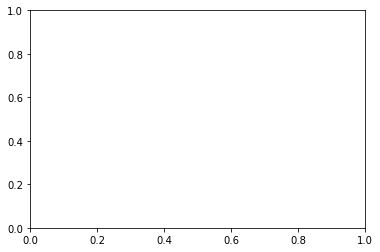

In [134]:



fig, ax = plt.subplots()
ax = 